### United States Real Estate Analysis ###

Please Note: Our primary csv for real estate data contained more than 2M datapoints and was significantly larger than GitHub allowed (170.57 MB). As such, we trimmed down our dataset logically with the following code prior to upload:

-Removed unnecessay columns (Brokered By & Street) by only including columns of interest:
dataframe = dataframe[["status", "price", "bed", "bath", "acre_lot", "city", "state", "zip_code", "house_size", "prev_sold_date"]]

-Removed U.S. Territories (Puerto Rico & Virgin Islands) to only include states within our analysis:
dataframe = dataframe.loc[(dataframe["state"] != "Puerto Rico") & (dataframe["state"] != "Virgin Islands")]

In [1]:
# Import appropriate dependencies
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
import scipy.stats as st
import time
import random
from api_codes import geoapify_key_one
from api_codes import openweather_key_one
from api_codes import geoapify_key_two
from api_codes import openweather_key_two
from api_codes import openweather_key_three

# Establish proper filepath to csv file
filepath = "Resources/real_estate.csv"

# Read csv file into initial dataframe and display
initial_dataset_df = pd.read_csv(filepath)
initial_dataset_df

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
0,for_sale,525000,3,3,0.45,Agawam,Massachusetts,1001,2314,6/25/14
1,for_sale,289900,3,2,0.36,Agawam,Massachusetts,1001,1276,10/12/12
2,for_sale,384900,3,2,0.46,Agawam,Massachusetts,1001,1476,11/20/86
3,for_sale,199999,3,2,1.76,Agawam,Massachusetts,1001,1968,9/19/08
4,for_sale,419000,4,2,2.00,Pelham,Massachusetts,1002,1607,7/25/05
...,...,...,...,...,...,...,...,...,...,...
1048570,sold,520000,3,3,0.09,Newberg,Oregon,97132,1630,2/18/22
1048571,sold,635000,5,3,0.14,Beaverton,Oregon,97007,2618,2/18/22
1048572,sold,749000,4,2,0.20,Wilsonville,Oregon,97070,2492,2/18/22
1048573,sold,485000,3,2,0.13,Newberg,Oregon,97132,1364,2/18/22


In [2]:
# First, we should locate if there are any duplicate entries within our dataset
initial_dataset_df.duplicated().sum()

1216

In [3]:
# Drop the 1,216 duplicate values from our dataframe
initial_dataset_df.drop_duplicates(inplace=True)

In [4]:
# Confirm new count of rows minus the removed duplicate datapoints
initial_dataset_df.count()

status            1047359
price             1047359
bed               1047359
bath              1047359
acre_lot          1047359
city              1047359
state             1047359
zip_code          1047359
house_size        1047359
prev_sold_date    1047359
dtype: int64

In [5]:
# Coverting date format to datetime within pandas
initial_dataset_df['prev_sold_date'] = pd.to_datetime(initial_dataset_df['prev_sold_date'], format='%m/%d/%y')
# Display updated dataframe to confirm datetime formatting
initial_dataset_df.head()

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
0,for_sale,525000,3,3,0.45,Agawam,Massachusetts,1001,2314,2014-06-25
1,for_sale,289900,3,2,0.36,Agawam,Massachusetts,1001,1276,2012-10-12
2,for_sale,384900,3,2,0.46,Agawam,Massachusetts,1001,1476,1986-11-20
3,for_sale,199999,3,2,1.76,Agawam,Massachusetts,1001,1968,2008-09-19
4,for_sale,419000,4,2,2.00,Pelham,Massachusetts,1002,1607,2005-07-25


In [6]:
# Filtering number of bedroom to less than or equal to 5 & dates after 2015
filtered_df = initial_dataset_df.loc[(initial_dataset_df['bed'] <= 5) & (initial_dataset_df['prev_sold_date'] > "2015-01-01")]
# Count this fitlered dataframe to return the number of datapoints that meet our selection criteria
filtered_df.count()

status            806953
price             806953
bed               806953
bath              806953
acre_lot          806953
city              806953
state             806953
zip_code          806953
house_size        806953
prev_sold_date    806953
dtype: int64

In [7]:
# Splitting dataset into three distinct individual states for analysis (East US / Central US/ West US)
pa_df = initial_dataset_df.loc[(initial_dataset_df['state'] == "Pennsylvania")]
wi_df = initial_dataset_df.loc[(initial_dataset_df['state'] == "Wisconsin")]
wa_df = initial_dataset_df.loc[(initial_dataset_df['state'] == "Washington")]

In [8]:
# Display Pennsylvania dataframe
pa_df

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
18640,for_sale,279900,3,3,1.14,Lower Mt Bethel Township,Pennsylvania,18013,1865,2017-08-01
18641,for_sale,129900,3,1,0.56,East Stroudsburg,Pennsylvania,18301,1050,1970-11-10
18643,for_sale,189900,2,3,0.03,Stroudsburg,Pennsylvania,18360,1230,2005-04-01
18645,for_sale,259900,3,2,0.13,East Stroudsburg,Pennsylvania,18301,1306,2021-09-03
18646,for_sale,135900,3,1,0.09,Bangor,Pennsylvania,18013,904,2019-03-26
...,...,...,...,...,...,...,...,...,...,...
727642,sold,210000,3,2,0.50,Beaver Falls,Pennsylvania,15010,2016,2022-04-22
727644,sold,219000,7,4,0.16,New Brighton,Pennsylvania,15066,5600,2022-04-21
727784,sold,169900,2,1,1.09,New Castle,Pennsylvania,16105,1165,2021-11-09
727813,sold,255000,4,3,0.46,New Castle,Pennsylvania,16105,2450,2022-01-20


In [9]:
# Display Washington dataframe
wa_df

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
365274,for_sale,282000,4,2,0.32,Clarkston,Washington,99403,1628,2007-01-31
365275,for_sale,490000,3,2,0.42,Clarkston,Washington,99403,1789,2006-04-18
365278,for_sale,479000,4,4,0.24,Clarkston,Washington,99403,2652,2007-06-04
365279,for_sale,550000,4,3,0.27,Clarkston,Washington,99403,2510,2015-04-17
365281,for_sale,649000,4,2,0.27,Asotin,Washington,99402,1623,2021-01-07
...,...,...,...,...,...,...,...,...,...,...
1046588,sold,60000,2,1,0.26,Wishram,Washington,98673,1160,2022-01-13
1046653,sold,314370,3,2,5.07,Goldendale,Washington,98620,1763,2022-04-27
1046701,sold,410000,3,2,0.55,Dallesport,Washington,98617,1809,2021-11-22
1046703,sold,250000,2,2,45.00,Goldendale,Washington,98620,924,2021-11-19


In [10]:
# Display Wisconsin dataframe
wi_df

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
238260,for_sale,179900,2,1,2.00,Pembine,Wisconsin,54156,1248,2020-08-20
238305,for_sale,239900,3,2,26.37,Pembine,Wisconsin,54156,1630,2017-04-13
238307,for_sale,179900,3,2,1.10,Pembine,Wisconsin,54156,1824,2004-07-29
238309,for_sale,320000,3,2,36.99,Wausaukee,Wisconsin,54177,1626,2003-04-08
238310,for_sale,339000,3,2,2.54,Florence,Wisconsin,54121,1684,2017-06-12
...,...,...,...,...,...,...,...,...,...,...
785402,sold,79900,3,2,0.26,Janesville,Wisconsin,53548,1588,2022-03-25
785403,sold,115000,3,2,0.14,Beloit,Wisconsin,53511,1006,2022-03-25
785404,sold,262500,2,2,0.26,Janesville,Wisconsin,53545,1215,2022-04-08
785405,sold,149900,2,2,0.17,Beloit,Wisconsin,53511,1092,2022-04-08


### Wisconsin Analysis ###

In [11]:
# Determine and eliminate price outliers within the Wisconsin dataframe via IQR range/bound calculations
upper_q3 = wi_df['price'].quantile(0.75)
lower_q1 = wi_df['price'].quantile(0.25)
iqr = upper_q3 - lower_q1
upper_bound = upper_q3 + (1.5 * iqr)
lower_bound = lower_q1 - (1.5 * iqr)
wi_df_clean = wi_df[(wi_df['price'] <= upper_bound) & (wi_df['price'] >= lower_bound)]
# Exclude rows where listing price is less than $5,000 to eliminate incorrect datapoints due to data entry error
wi_df_clean = wi_df_clean[wi_df_clean['price'] > 5000]
wi_df_clean
# 12,985 rows minus this new dataframe's rows 12,352 = the number of removed rows with outlier prices/less than $5,000 (633)

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
238260,for_sale,179900,2,1,2.00,Pembine,Wisconsin,54156,1248,2020-08-20
238305,for_sale,239900,3,2,26.37,Pembine,Wisconsin,54156,1630,2017-04-13
238307,for_sale,179900,3,2,1.10,Pembine,Wisconsin,54156,1824,2004-07-29
238309,for_sale,320000,3,2,36.99,Wausaukee,Wisconsin,54177,1626,2003-04-08
238310,for_sale,339000,3,2,2.54,Florence,Wisconsin,54121,1684,2017-06-12
...,...,...,...,...,...,...,...,...,...,...
785402,sold,79900,3,2,0.26,Janesville,Wisconsin,53548,1588,2022-03-25
785403,sold,115000,3,2,0.14,Beloit,Wisconsin,53511,1006,2022-03-25
785404,sold,262500,2,2,0.26,Janesville,Wisconsin,53545,1215,2022-04-08
785405,sold,149900,2,2,0.17,Beloit,Wisconsin,53511,1092,2022-04-08


In [12]:
# Determine measures of central tendency and min/max for Wisconsin's listing prices without the outliers
wi_prices = wi_df_clean['price']

wi_prices_mean = np.mean(wi_prices)
print(f"The mean listing price in the Wisconsin dataset is ${wi_prices_mean.round(2)}")

wi_prices_median = np.median(wi_prices)
print(f"The median listing price in the Wisconsin dataset is ${wi_prices_median}")

wi_prices_mode = st.mode(wi_prices)
print(f"The mode listing price in the Wisconsin dataset is ${wi_prices_mode[0]}")

wi_prices_max = wi_prices.max()
print(f"The maximum listing price in the Wisconsin dataset is ${wi_prices_max}")

wi_prices_min = wi_prices.min()
print(f"The minimum listing price in the Wisconsin dataset is ${wi_prices_min}")

The mean listing price in the Wisconsin dataset is $275966.59
The median listing price in the Wisconsin dataset is $250000.0
The mode listing price in the Wisconsin dataset is $149900
The maximum listing price in the Wisconsin dataset is $694900
The minimum listing price in the Wisconsin dataset is $9900


The r-value is: 0.3346754669711353
The r-squared value is: 0.11200766819234749


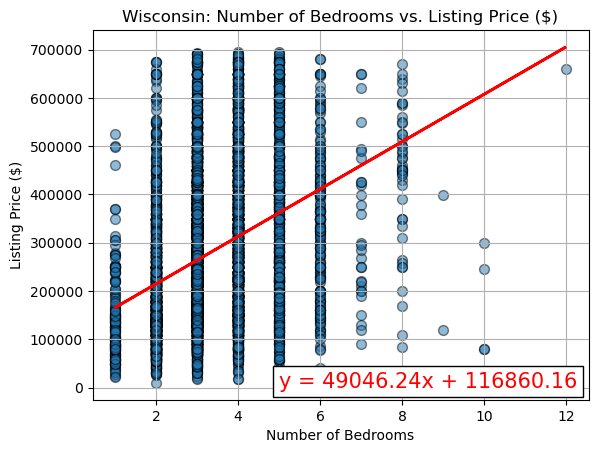

In [13]:
# Determine and visualize the correlation between number of bedrooms and listing price for the Wisconsin dataset
x_values = wi_df_clean['bed']
y_values = wi_df_clean['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, wi_bedvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (5,-1), fontsize=15, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Number of Bedrooms")
plt.ylabel("Listing Price ($)")
plt.title("Wisconsin: Number of Bedrooms vs. Listing Price ($)")
print(f"The r-value is: {wi_bedvprice_rvalue}")
print(f"The r-squared value is: {wi_bedvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Wi_Fig1.png")
plt.show()


The r-value is: 0.6270643413835789
The r-squared value is: 0.3932096882348216


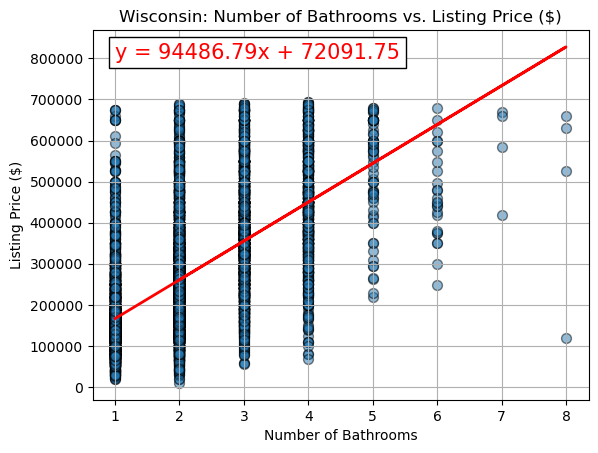

In [14]:
# Determine and visualize the correlation between number of bathrooms and listing price for the Wisconsin dataset
x_values = wi_df_clean['bath']
y_values = wi_df_clean['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, wi_bathvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (1,800000), fontsize=15, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Number of Bathrooms")
plt.ylabel("Listing Price ($)")
plt.title("Wisconsin: Number of Bathrooms vs. Listing Price ($)")
print(f"The r-value is: {wi_bathvprice_rvalue}")
print(f"The r-squared value is: {wi_bathvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Wi_Fig2.png")
plt.show()


The r-value is: 0.10915905701703178
The r-squared value is: 0.011915699728847595


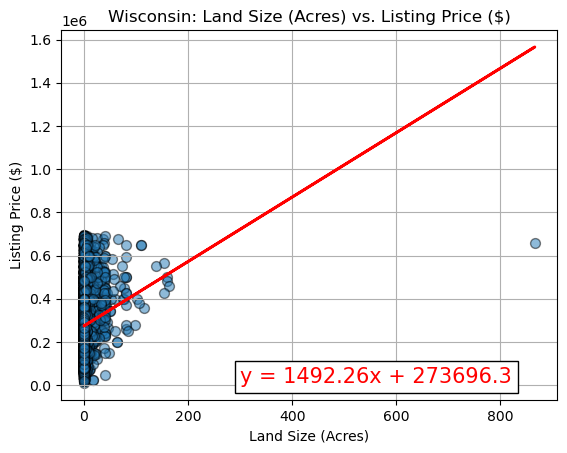

In [15]:
# Determine and visualize the correlation between land size and listing price for the Wisconsin dataset
x_values = wi_df_clean['acre_lot']
y_values = wi_df_clean['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, wi_landvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (300,10000), fontsize=15, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Land Size (Acres)")
plt.ylabel("Listing Price ($)")
plt.title("Wisconsin: Land Size (Acres) vs. Listing Price ($)")
print(f"The r-value is: {wi_landvprice_rvalue}")
print(f"The r-squared value is: {wi_landvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Wi_Fig3.png")
plt.show()


The r-value is: 0.636516699216223
The r-squared value is: 0.4051535083811157


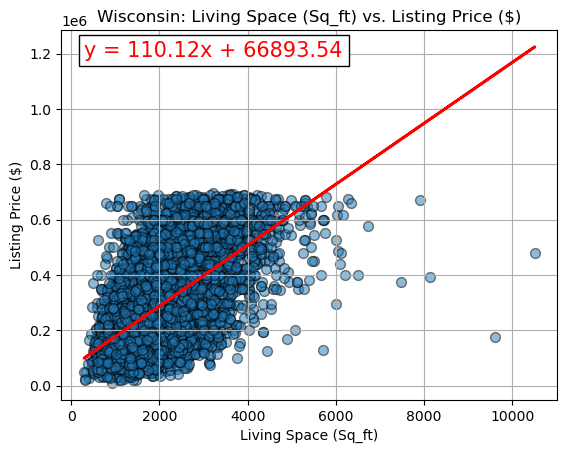

In [16]:
# Determine and visualize the correlation between living space and listing price for the Wisconsin dataset
x_values = wi_df_clean['house_size']
y_values = wi_df_clean['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, wi_livingvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (300,1190000), fontsize=15, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Living Space (Sq_ft)")
plt.ylabel("Listing Price ($)")
plt.title("Wisconsin: Living Space (Sq_ft) vs. Listing Price ($)")
print(f"The r-value is: {wi_livingvprice_rvalue}")
print(f"The r-squared value is: {wi_livingvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Wi_Fig4.png")
plt.show()


### Wisconsin OpenWeather API for Maximum Temperature Retrieval ###

In [17]:
# Utilize the OpenWeather API to obtain city specific Latitude, Longitude and Maximum Temperature values
# Establish a base url for request as well as an empty lists to hold specified results 
base_url = "http://api.openweathermap.org/data/2.5/weather?appid=" + openweather_key_one + "&units=imperial" + "&q="
wi_city_data = []
wi_city_names = wi_df_clean['city'].unique()

# Run for loop for each city
for city in wi_city_names:

    # Establish enpoint target url for each unique city name
    target_url = base_url + city + ",WI,US"

    # Run API request
    try:

        # Parse JSON response and retrieve data
        wi_response = requests.get(target_url).json()

        # Data retrieval for Latitude, Longitude and Max Temperature
        city_lat = wi_response["coord"]["lat"]
        city_long = wi_response["coord"]["lon"]
        city_temp = wi_response["main"]["temp_max"]

        # Add the retrived data to our previously established dictionary
        wi_city_data.append({"city": city,
                            "Latitude": city_lat,
                            "Longitude": city_long,
                            "Max Temperature": city_temp})

    # Include an except clause to handle potential errors and skip to the next city
    except:
        print(f"City not found: {city}")
        pass

# Display when process is complete
print("Data Retrieval Complete!")

City not found: Porterfield T Wi
City not found: Marinette C Wi
City not found: Peshtigo T Wi
City not found: Florence T Wi
City not found: Alvin T Wi
City not found: Hurley C Wi
City not found: Land O Lakes
City not found: Hillpoint
City not found: Lincoln Township
City not found: Laketown
City not found: Black Brook
City not found: Crystal Lake Township
City not found: Apple River Township
City not found: Johnstown Township
City not found: Richmond Township
City not found: Kinnickinnic
City not found: Baileys Harbor
City not found: Ellison Bay
City not found: Sister Bay
City not found: Washington Island
City not found: W6941 Cth
City not found: Elcho
City not found: Lake Holcombe
City not found: Newald
City not found: Draper Township
City not found: Plum Lake
City not found: Exeland
City not found: Ojibwa
City not found: Meadowbrook Township
City not found: Thornapple Township
City not found: Frankfort Township
City not found: Lakeland Township
City not found: Rusk Township
City not 

In [18]:
# Convert our populated dictionary into a dataframe and display
wi_city_data_df = pd.DataFrame(wi_city_data)
wi_city_data_df

,city,Latitude,Longitude,Max Temperature
0,Pembine,45.6352,-87.9910,54.41
1,Wausaukee,45.3708,-87.9523,56.71
2,Florence,45.9222,-88.2518,53.24
3,Marinette,45.1000,-87.6307,60.85
4,Egg Harbor,45.0464,-87.2971,57.58
...,...,...,...,...
655,Grand Chute,44.3043,-88.4392,60.84
656,Leopolis,44.7680,-88.8448,55.11
657,Poy Sippi,44.1359,-88.9958,60.85
658,Pine River,51.7861,-100.5297,58.87


### Wisconsin Geoapify API for Population Retrieval ###

In [19]:
# Add new column to hold retrieved city population values
wi_city_data_df["Population"] = ""

# Establish base url and params dictionary for API call
base_url = "https://api.geoapify.com/v2/place-details"
params = {
    "apiKey": geoapify_key_one,
}

# Loop through each row (city) within dataframe to obtain population results
for index, row in wi_city_data_df.iterrows():

    # Append appropriate required parameters to return population for each lat/long input
    params["lat"] = row.loc['Latitude']
    params["lon"] = row.loc['Longitude']
    city = row.loc['city']

    # Make API request and convert to JSON format
    response = requests.get(base_url, params=params).json()

    # Append our population column with the retrieved population value and display progress indicator
    try:
        wi_city_data_df.loc[index, "Population"] = response['features'][0]['properties']['datasource']['raw']['population']
        print(f"Population of {city} found")

    # If error encountered, fill population column with NaN and display indicator
    except (KeyError, IndexError):
        wi_city_data_df.loc[index, "Population"] = np.nan
        print(f"Population of {city} not found")

# Print completion message
print("-----------------------")
print("Data Retrieval Complete!")
print("-----------------------")

# Display updated dataframe with returned population values
wi_city_data_df

Population of Pembine found
Population of Wausaukee not found
Population of Florence found
Population of Marinette found
Population of Egg Harbor found
Population of Peshtigo found
Population of Niagara found
Population of Porterfield found
Population of Conover found
Population of Mercer found
Population of Manitowish Waters not found
Population of Minocqua found
Population of Arbor Vitae not found
Population of Winchester found
Population of Presque Isle not found
Population of Lac du Flambeau found
Population of Boulder Junction not found
Population of Woodruff not found
Population of Patch Grove found
Population of Cassville found
Population of Dickeyville not found
Population of Glen Haven not found
Population of Potosi not found
Population of Prairie du Chien not found
Population of Cuba City found
Population of Platteville not found
Population of Benton found
Population of Shullsburg not found
Population of Hazel Green found
Population of Lancaster not found
Population of De Sot

,city,Latitude,Longitude,Max Temperature,Population
0,Pembine,45.6352,-87.9910,54.41,1078
1,Wausaukee,45.3708,-87.9523,56.71,NaN
2,Florence,45.9222,-88.2518,53.24,592
3,Marinette,45.1000,-87.6307,60.85,11009
4,Egg Harbor,45.0464,-87.2971,57.58,250
...,...,...,...,...,...
655,Grand Chute,44.3043,-88.4392,60.84,NaN
656,Leopolis,44.7680,-88.8448,55.11,NaN
657,Poy Sippi,44.1359,-88.9958,60.85,NaN
658,Pine River,51.7861,-100.5297,58.87,NaN


In [20]:
# Drop all cities where we were unable to retrieve a population value and display dataframe
wi_city_data_df = wi_city_data_df.loc[pd.notna(wi_city_data_df["Population"])]
wi_city_data_df
# This dataframe indicates we were able to obtain Max Temperature and Population results for cities across 346 listings

,city,Latitude,Longitude,Max Temperature,Population
0,Pembine,45.6352,-87.9910,54.41,1078
2,Florence,45.9222,-88.2518,53.24,592
3,Marinette,45.1000,-87.6307,60.85,11009
4,Egg Harbor,45.0464,-87.2971,57.58,250
5,Peshtigo,45.0544,-87.7493,58.98,3287
...,...,...,...,...,...
642,Comstock,46.6594,-96.7484,58.91,119
643,Trade Lake,45.6897,-92.5930,58.84,949
646,Maple,46.5897,-91.7207,53.94,676
648,Sarona,45.7111,-91.8066,58.78,408


In [21]:
# Merge our temperature and population dataframe with our master Wisconsin dataframe & display
# Execute left merge to maintain original dataframe integrity prior to dropping null values in combine dataframe
wi_merged = pd.merge(wi_df_clean, wi_city_data_df, how='left', on='city')
wi_merged

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,Latitude,Longitude,Max Temperature,Population
0,for_sale,179900,2,1,2.00,Pembine,Wisconsin,54156,1248,2020-08-20,45.6352,-87.9910,54.41,1078
1,for_sale,239900,3,2,26.37,Pembine,Wisconsin,54156,1630,2017-04-13,45.6352,-87.9910,54.41,1078
2,for_sale,179900,3,2,1.10,Pembine,Wisconsin,54156,1824,2004-07-29,45.6352,-87.9910,54.41,1078
3,for_sale,320000,3,2,36.99,Wausaukee,Wisconsin,54177,1626,2003-04-08,NaN,NaN,NaN,NaN
4,for_sale,339000,3,2,2.54,Florence,Wisconsin,54121,1684,2017-06-12,45.9222,-88.2518,53.24,592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12347,sold,79900,3,2,0.26,Janesville,Wisconsin,53548,1588,2022-03-25,NaN,NaN,NaN,NaN
12348,sold,115000,3,2,0.14,Beloit,Wisconsin,53511,1006,2022-03-25,NaN,NaN,NaN,NaN
12349,sold,262500,2,2,0.26,Janesville,Wisconsin,53545,1215,2022-04-08,NaN,NaN,NaN,NaN
12350,sold,149900,2,2,0.17,Beloit,Wisconsin,53511,1092,2022-04-08,NaN,NaN,NaN,NaN


In [22]:
# Drop all rows where we were unable to populate both temperature and population
wi_merged = wi_merged.dropna()
wi_merged
# This dataframe indicates we were able to populate Max Temperature and Population results across 3,908 listings

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,Latitude,Longitude,Max Temperature,Population
0,for_sale,179900,2,1,2.00,Pembine,Wisconsin,54156,1248,2020-08-20,45.6352,-87.9910,54.41,1078
1,for_sale,239900,3,2,26.37,Pembine,Wisconsin,54156,1630,2017-04-13,45.6352,-87.9910,54.41,1078
2,for_sale,179900,3,2,1.10,Pembine,Wisconsin,54156,1824,2004-07-29,45.6352,-87.9910,54.41,1078
4,for_sale,339000,3,2,2.54,Florence,Wisconsin,54121,1684,2017-06-12,45.9222,-88.2518,53.24,592
5,for_sale,129000,4,1,0.14,Marinette,Wisconsin,54143,1443,2016-07-22,45.1000,-87.6307,60.85,11009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12230,sold,152000,3,2,0.13,Superior,Wisconsin,54880,1624,2021-11-05,46.7208,-92.1041,51.48,26960
12231,sold,162500,3,2,0.16,Superior,Wisconsin,54880,1760,2021-11-05,46.7208,-92.1041,51.48,26960
12232,sold,127500,2,1,0.10,Superior,Wisconsin,54880,859,2022-02-25,46.7208,-92.1041,51.48,26960
12315,sold,174900,4,3,0.21,Clinton,Wisconsin,53525,1825,2022-01-28,42.5578,-88.8651,70.90,2250


The r-value is: 0.2490175375994328
The r-squared value is: 0.06200973403208492


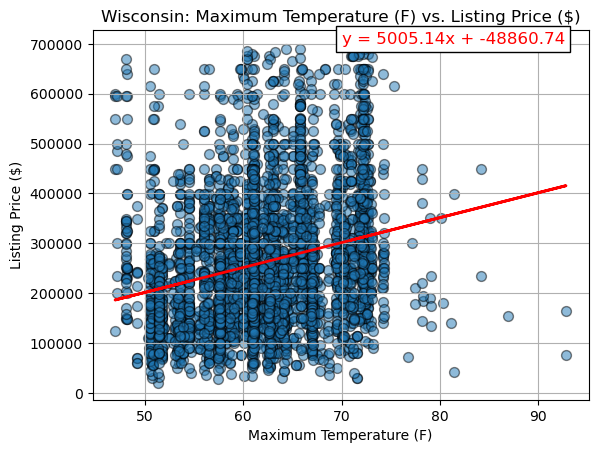

In [23]:
# Determine and visualize the correlation between maximum temperature and listing price for the merged Wisconsin dataset
x_values = wi_merged['Max Temperature']
y_values = wi_merged['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, wi_tempvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (70,700000), fontsize=12, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Maximum Temperature (F)")
plt.ylabel("Listing Price ($)")
plt.title("Wisconsin: Maximum Temperature (F) vs. Listing Price ($)")
print(f"The r-value is: {wi_tempvprice_rvalue}")
print(f"The r-squared value is: {wi_tempvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Wi_Fig5.png")
plt.show()


In [24]:
# Convert population column from object to float datatype for regression calculation
wi_merged['Population'] = wi_merged['Population'].astype(float)

/var/folders/jt/y3cfddrx4zsdlyrvrktbcyl40000gn/T/ipykernel_76331/1019337400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wi_merged['Population'] = wi_merged['Population'].astype(float)


The r-value is: -0.0055644045978788135
The r-squared value is: 3.096259852889488e-05


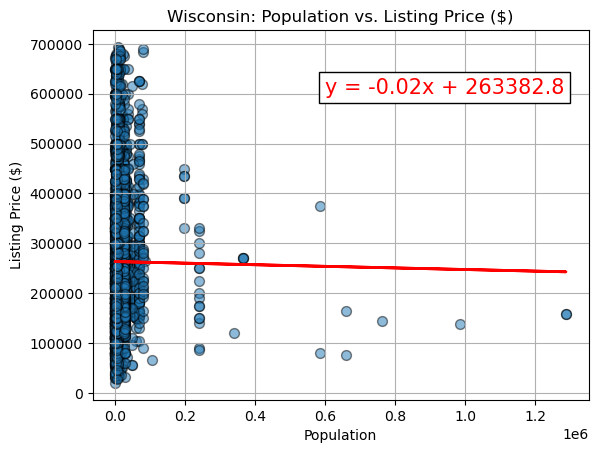

In [25]:
# Determine and visualize the correlation between population and listing price for the merged Wisconsin dataset
x_values = wi_merged['Population']
y_values = wi_merged['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, wi_popvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (600000,600000), fontsize=15, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Population")
plt.ylabel("Listing Price ($)")
plt.title("Wisconsin: Population vs. Listing Price ($)")
print(f"The r-value is: {wi_popvprice_rvalue}")
print(f"The r-squared value is: {wi_popvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Wi_Fig6.png")
plt.show()


### Washington Analysis ###

In [26]:
# Determine and eliminate price outliers within the Washington dataframe via IQR range/bound calculations
upper_q3 = wa_df['price'].quantile(0.75)
lower_q1 = wa_df['price'].quantile(0.25)
iqr = upper_q3 - lower_q1
upper_bound = upper_q3 + (1.5 * iqr)
lower_bound = lower_q1 - (1.5 * iqr)
wa_df_clean = wa_df[(wa_df['price'] <= upper_bound) & (wa_df['price'] >= lower_bound)]
# Exclude rows where listing price is less than $5,000 to eliminate incorrect datapoints due to data entry error
wa_df_clean = wa_df_clean[wa_df_clean['price'] > 5000]
wa_df_clean
# 11,781 rows minus this new dataframe's rows 10,883 = the number of removed rows with outlier prices/less than $5,000 (898)

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
365274,for_sale,282000,4,2,0.32,Clarkston,Washington,99403,1628,2007-01-31
365275,for_sale,490000,3,2,0.42,Clarkston,Washington,99403,1789,2006-04-18
365278,for_sale,479000,4,4,0.24,Clarkston,Washington,99403,2652,2007-06-04
365279,for_sale,550000,4,3,0.27,Clarkston,Washington,99403,2510,2015-04-17
365281,for_sale,649000,4,2,0.27,Asotin,Washington,99402,1623,2021-01-07
...,...,...,...,...,...,...,...,...,...,...
1046588,sold,60000,2,1,0.26,Wishram,Washington,98673,1160,2022-01-13
1046653,sold,314370,3,2,5.07,Goldendale,Washington,98620,1763,2022-04-27
1046701,sold,410000,3,2,0.55,Dallesport,Washington,98617,1809,2021-11-22
1046703,sold,250000,2,2,45.00,Goldendale,Washington,98620,924,2021-11-19


In [27]:
# Determine measures of central tendency and min/max for Washington's listing prices without the outliers
wa_prices = wa_df_clean['price']

wa_prices_mean = np.mean(wa_prices)
print(f"The mean listing price in the Washington dataset is ${wa_prices_mean.round(2)}")

wa_prices_median = np.median(wa_prices)
print(f"The median listing price in the Washington dataset is ${wa_prices_median}")

wa_prices_mode = st.mode(wa_prices)
print(f"The mode listing price in the Washington dataset is ${wa_prices_mode[0]}")

wa_prices_max = wa_prices.max()
print(f"The maximum listing price in the Washington dataset is ${wa_prices_max}")

wa_prices_min = wa_prices.min()
print(f"The minimum listing price in the Washington dataset is ${wa_prices_min}")

The mean listing price in the Washington dataset is $631944.84
The median listing price in the Washington dataset is $559000.0
The mode listing price in the Washington dataset is $425000
The maximum listing price in the Washington dataset is $1539000
The minimum listing price in the Washington dataset is $47900


The r-value is: 0.34628653222328315
The r-squared value is: 0.11991436239922693


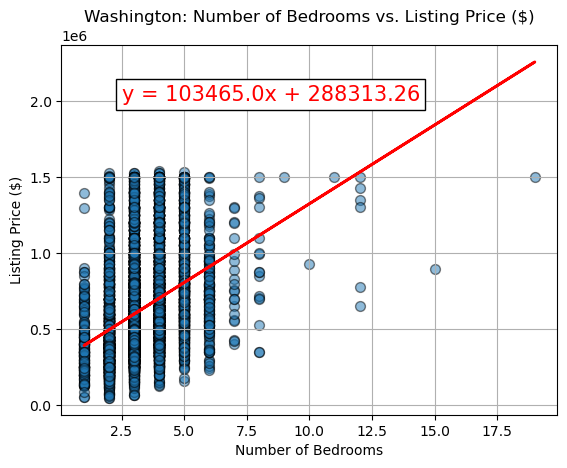

In [28]:
# Determine and visualize the correlation between number of bedrooms and listing price for the Washington dataset
x_values = wa_df_clean['bed']
y_values = wa_df_clean['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, wa_bedvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (2.5,2000000), fontsize=15, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Number of Bedrooms")
plt.ylabel("Listing Price ($)")
plt.title("Washington: Number of Bedrooms vs. Listing Price ($)")
print(f"The r-value is: {wa_bedvprice_rvalue}")
print(f"The r-squared value is: {wa_bedvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Wa_Fig1.png")
plt.show()


The r-value is: 0.49146328992067473
The r-squared value is: 0.2415361653396532


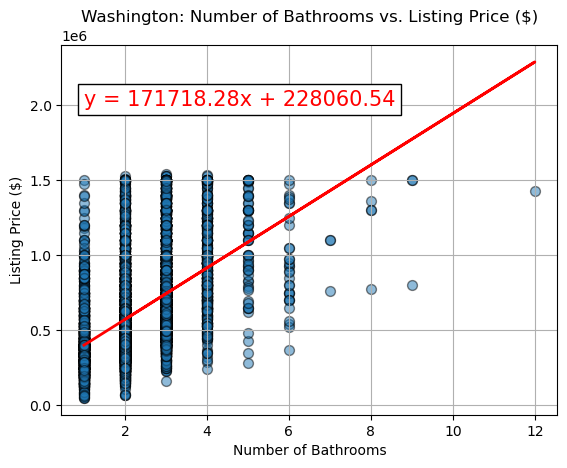

In [29]:
# Determine and visualize the correlation between number of bathrooms and listing price for the Washington dataset
x_values = wa_df_clean['bath']
y_values = wa_df_clean['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, wa_bathvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (1,2000000), fontsize=15, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Number of Bathrooms")
plt.ylabel("Listing Price ($)")
plt.title("Washington: Number of Bathrooms vs. Listing Price ($)")
print(f"The r-value is: {wa_bathvprice_rvalue}")
print(f"The r-squared value is: {wa_bathvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Wa_Fig2.png")
plt.show()


The r-value is: 0.10520924858643985
The r-squared value is: 0.011068985988123295


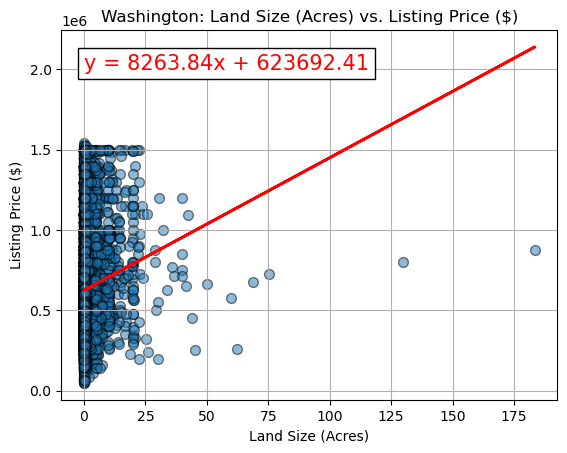

In [30]:
# Determine and visualize the correlation between land size and listing price for the Washington dataset
x_values = wa_df_clean['acre_lot']
y_values = wa_df_clean['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, wa_landvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (0,2000000), fontsize=15, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Land Size (Acres)")
plt.ylabel("Listing Price ($)")
plt.title("Washington: Land Size (Acres) vs. Listing Price ($)")
print(f"The r-value is: {wa_landvprice_rvalue}")
print(f"The r-squared value is: {wa_landvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Wa_Fig3.png")
plt.show()


The r-value is: 0.5735464554901053
The r-squared value is: 0.32895553660526333


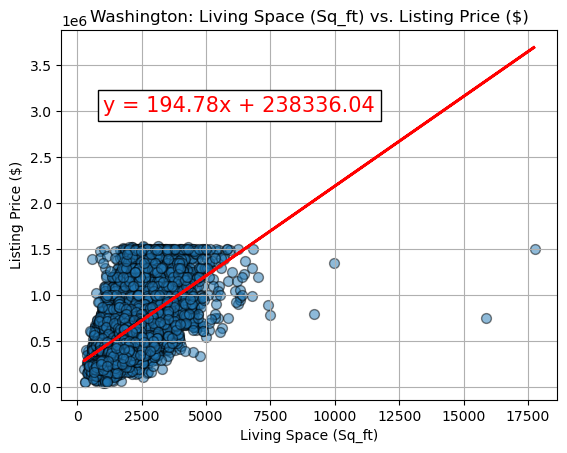

In [31]:
# Determine and visualize the correlation between living space and listing price for the Washington dataset
x_values = wa_df_clean['house_size']
y_values = wa_df_clean['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, wa_livingvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (1000,3000000), fontsize=15, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Living Space (Sq_ft)")
plt.ylabel("Listing Price ($)")
plt.title("Washington: Living Space (Sq_ft) vs. Listing Price ($)")
print(f"The r-value is: {wa_livingvprice_rvalue}")
print(f"The r-squared value is: {wa_livingvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Wa_Fig4.png")
plt.show()


### Washington OpenWeather API for Maximum Temperature Retrieval ###

In [32]:
# Utilize the OpenWeather API to obtain city specific Latitude, Longitude and Maximum Temperature values
# Establish a base url for request as well as an empty lists to hold specified results 
base_url = "http://api.openweathermap.org/data/2.5/weather?appid=" + openweather_key_two + "&units=imperial" + "&q="
wa_city_data = []
wa_city_names = wa_df_clean['city'].unique()

# Run for loop for each city
for city in wa_city_names:

    # Establish enpoint target url for each unique city name
    target_url = base_url + city + ",WA,US"

    # Run API request
    try:

        # Parse JSON response and retrieve data
        wa_response = requests.get(target_url).json()

        # Data retrieval for Latitude, Longitude and Max Temperature
        city_lat = wa_response["coord"]["lat"]
        city_long = wa_response["coord"]["lon"]
        city_temp = wa_response["main"]["temp_max"]

        # Add the retrived data to our previously established dictionary
        wa_city_data.append({"city": city,
                            "Latitude": city_lat,
                            "Longitude": city_long,
                            "Max Temperature": city_temp})

    # Include an except clause to handle potential errors and skip to the next city
    except:
        print(f"City not found: {city}")
        pass

# Display when process is complete
print("Data Retrieval Complete!")

City not found: Ilwaco
City not found: Greenwater
City not found: Lake Tapps
City not found: Sedro Woolley
City not found: Hat Island
City not found: Center Island
City not found: Blakely Island
City not found: Lopez Island
City not found: San Juan Island
City not found: Orcas Island
City not found: Skykomish
City not found: Camano Island
City not found: La Conner
City not found: Decatur Island
City not found: Marblemount
City not found: Anderson Island
City not found: Sekiu
City not found: Brinnon
City not found: Clallam Bay
City not found: Port Hadlock
City not found: Nordland
City not found: Quilcene
City not found: Grayland
City not found: Copalis Beach
City not found: Pe Ell
City not found: Silverlake
City not found: Grays River
City not found: Twisp
City not found: Coulee City
City not found: Moxee
City not found: Metaline
City not found: Metaline Falls
Data Retrieval Complete!


In [33]:
# Convert our populated dictionary into a dataframe and display
wa_city_data_df = pd.DataFrame(wa_city_data)
wa_city_data_df

,city,Latitude,Longitude,Max Temperature
0,Clarkston,46.4163,-117.0452,76.59
1,Asotin,46.3393,-117.0482,76.24
2,Pullman,46.7313,-117.1796,66.85
3,Uniontown,39.9001,-79.7164,73.62
4,Newport,47.5712,-122.1807,55.74
...,...,...,...,...
331,Oakesdale,47.1282,-117.2427,65.25
332,Tekoa,47.2234,-117.0709,65.12
333,Albion,41.6908,-98.0037,73.06
334,Wishram,45.6589,-120.9654,74.21


### Washington Geoapify API for Population Retrieval ###

In [34]:
# Add new column to hold retrieved city population values
wa_city_data_df["Population"] = ""

# Establish base url and params dictionary for API call
base_url = "https://api.geoapify.com/v2/place-details"
params = {
    "apiKey": geoapify_key_two,
}

# Loop through each row (city) within dataframe to obtain population results
for index, row in wa_city_data_df.iterrows():

    # Append appropriate required parameters to return population for each lat/long input
    params["lat"] = row.loc['Latitude']
    params["lon"] = row.loc['Longitude']
    city = row.loc['city']

    # Make API request and convert to JSON format
    response = requests.get(base_url, params=params).json()

    # Append our population column with the retrieved population value and display progress indicator
    try:
        wa_city_data_df.loc[index, "Population"] = response['features'][0]['properties']['datasource']['raw']['population']
        print(f"Population of {city} found")

    # If error encountered, fill population column with NaN and display indicator
    except (KeyError, IndexError):
        wa_city_data_df.loc[index, "Population"] = np.nan
        print(f"Population of {city} not found")

# Print completion message
print("-----------------------")
print("Data Retrieval Complete!")
print("-----------------------")

# Display updated dataframe with returned population values
wa_city_data_df

Population of Clarkston found
Population of Asotin found
Population of Pullman not found
Population of Uniontown found
Population of Newport not found
Population of Latah not found
Population of Fairfield found
Population of Palouse found
Population of Farmington not found
Population of Garfield not found
Population of Cusick not found
Population of Usk not found
Population of Washougal not found
Population of Carson not found
Population of North Bonneville found
Population of Home Valley not found
Population of Underwood not found
Population of Stevenson not found
Population of Lyle not found
Population of Kalama not found
Population of Woodland not found
Population of La Center not found
Population of Ridgefield not found
Population of Kelso not found
Population of Carrolls not found
Population of Battle Ground not found
Population of Amboy not found
Population of Seaview found
Population of Long Beach found
Population of Chinook found
Population of Vancouver not found
Population of 

,city,Latitude,Longitude,Max Temperature,Population
0,Clarkston,46.4163,-117.0452,76.59,7161
1,Asotin,46.3393,-117.0482,76.24,1125
2,Pullman,46.7313,-117.1796,66.85,NaN
3,Uniontown,39.9001,-79.7164,73.62,9992
4,Newport,47.5712,-122.1807,55.74,NaN
...,...,...,...,...,...
331,Oakesdale,47.1282,-117.2427,65.25,NaN
332,Tekoa,47.2234,-117.0709,65.12,750
333,Albion,41.6908,-98.0037,73.06,NaN
334,Wishram,45.6589,-120.9654,74.21,NaN


In [35]:
# Drop all cities where we were unable to retrieve a population value and display dataframe
wa_city_data_df = wa_city_data_df.loc[pd.notna(wa_city_data_df["Population"])]
wa_city_data_df
# This dataframe indicates we were able to obtain Max Temperature and Population results for cities across 89 listings

,city,Latitude,Longitude,Max Temperature,Population
0,Clarkston,46.4163,-117.0452,76.59,7161
1,Asotin,46.3393,-117.0482,76.24,1125
3,Uniontown,39.9001,-79.7164,73.62,9992
6,Fairfield,38.2494,-122.0400,69.19,117133
7,Palouse,46.9101,-117.0753,66.49,917
...,...,...,...,...,...
316,Marcus,48.6632,-118.0683,66.18,168
321,Benton City,46.2632,-119.4878,74.88,3479
329,Paterson,40.9168,-74.1718,65.08,147000
330,Waitsburg,46.2704,-118.1533,70.75,1226


In [36]:
# Merge our temperature and population dataframe with our master Washington dataframe & display
# Execute left merge to maintain original dataframe integrity prior to dropping null values in combined dataframe
wa_merged = pd.merge(wa_df_clean, wa_city_data_df, how='left', on='city')
wa_merged

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,Latitude,Longitude,Max Temperature,Population
0,for_sale,282000,4,2,0.32,Clarkston,Washington,99403,1628,2007-01-31,46.4163,-117.0452,76.59,7161
1,for_sale,490000,3,2,0.42,Clarkston,Washington,99403,1789,2006-04-18,46.4163,-117.0452,76.59,7161
2,for_sale,479000,4,4,0.24,Clarkston,Washington,99403,2652,2007-06-04,46.4163,-117.0452,76.59,7161
3,for_sale,550000,4,3,0.27,Clarkston,Washington,99403,2510,2015-04-17,46.4163,-117.0452,76.59,7161
4,for_sale,649000,4,2,0.27,Asotin,Washington,99402,1623,2021-01-07,46.3393,-117.0482,76.24,1125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10878,sold,60000,2,1,0.26,Wishram,Washington,98673,1160,2022-01-13,NaN,NaN,NaN,NaN
10879,sold,314370,3,2,5.07,Goldendale,Washington,98620,1763,2022-04-27,45.8207,-120.8217,66.74,3453
10880,sold,410000,3,2,0.55,Dallesport,Washington,98617,1809,2021-11-22,NaN,NaN,NaN,NaN
10881,sold,250000,2,2,45.00,Goldendale,Washington,98620,924,2021-11-19,45.8207,-120.8217,66.74,3453


In [37]:
# Drop all rows where we were unable to populate both temperature and population
wa_merged = wa_merged.dropna()
wa_merged
# This dataframe indicates we were able to populate Max Temperature and Population results across 1,423 listings

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,Latitude,Longitude,Max Temperature,Population
0,for_sale,282000,4,2,0.32,Clarkston,Washington,99403,1628,2007-01-31,46.4163,-117.0452,76.59,7161
1,for_sale,490000,3,2,0.42,Clarkston,Washington,99403,1789,2006-04-18,46.4163,-117.0452,76.59,7161
2,for_sale,479000,4,4,0.24,Clarkston,Washington,99403,2652,2007-06-04,46.4163,-117.0452,76.59,7161
3,for_sale,550000,4,3,0.27,Clarkston,Washington,99403,2510,2015-04-17,46.4163,-117.0452,76.59,7161
4,for_sale,649000,4,2,0.27,Asotin,Washington,99402,1623,2021-01-07,46.3393,-117.0482,76.24,1125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10773,sold,148000,2,1,0.12,Tekoa,Washington,99033,1131,2022-03-03,47.2234,-117.0709,65.12,750
10856,sold,349500,3,2,0.30,Rockford,Washington,99030,2172,2022-04-22,42.2714,-89.0940,71.85,147070
10879,sold,314370,3,2,5.07,Goldendale,Washington,98620,1763,2022-04-27,45.8207,-120.8217,66.74,3453
10881,sold,250000,2,2,45.00,Goldendale,Washington,98620,924,2021-11-19,45.8207,-120.8217,66.74,3453


The r-value is: -0.20058223384181442
The r-squared value is: 0.04023323253297232


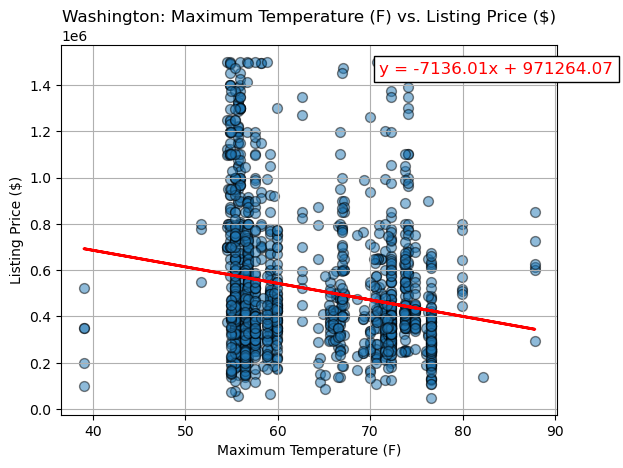

In [38]:
# Determine and visualize the correlation between maximum temperature and listing price for the merged Washington dataset
x_values = wa_merged['Max Temperature']
y_values = wa_merged['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, wa_tempvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (71,1450000), fontsize=12, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Maximum Temperature (F)")
plt.ylabel("Listing Price ($)")
plt.title("Washington: Maximum Temperature (F) vs. Listing Price ($)")
print(f"The r-value is: {wa_tempvprice_rvalue}")
print(f"The r-squared value is: {wa_tempvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Wa_Fig5.png")
plt.show()


In [39]:
# Convert population column from object to float datatype for regression calculation
wa_merged['Population'] = wa_merged['Population'].astype(float)

/var/folders/jt/y3cfddrx4zsdlyrvrktbcyl40000gn/T/ipykernel_76331/1094214991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wa_merged['Population'] = wa_merged['Population'].astype(float)


The r-value is: 0.03231179128359079
The r-squared value is: 0.0010440518559543337


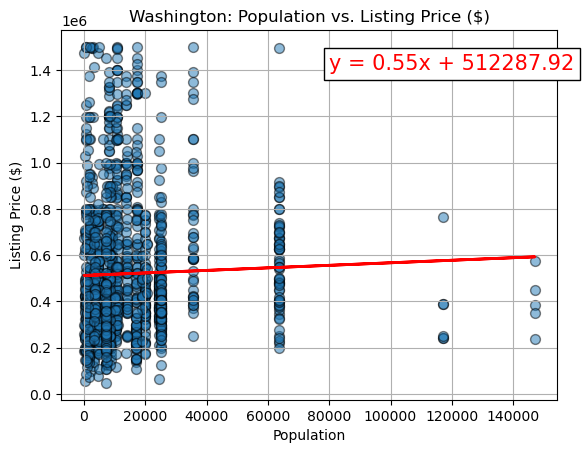

In [40]:
# Determine and visualize the correlation between population and listing price for the merged Washington dataset
x_values = wa_merged['Population']
y_values = wa_merged['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, wa_popvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (80000,1400000), fontsize=15, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Population")
plt.ylabel("Listing Price ($)")
plt.title("Washington: Population vs. Listing Price ($)")
print(f"The r-value is: {wa_popvprice_rvalue}")
print(f"The r-squared value is: {wa_popvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Wa_Fig6.png")
plt.show()


### Pennsylvania Analysis ###

In [41]:
# Determine and eliminate price outliers within the Pennsylvania dataframe via IQR range/bound calculations
upper_q3 = pa_df['price'].quantile(0.75)
lower_q1 = pa_df['price'].quantile(0.25)
iqr = upper_q3 - lower_q1
upper_bound = upper_q3 + (1.5 * iqr)
lower_bound = lower_q1 - (1.5 * iqr)
pa_df_clean = pa_df[(pa_df['price'] <= upper_bound) & (pa_df['price'] >= lower_bound)]
# Exclude rows where listing price is less than $5,000 to eliminate incorrect datapoints due to data entry error
pa_df_clean = pa_df_clean[pa_df_clean['price'] > 5000]
pa_df_clean
# 42,628 rows minus this new dataframe's rows 40,057 = the number of removed rows with outlier prices/less than $5,000 (2,571)

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
18640,for_sale,279900,3,3,1.14,Lower Mt Bethel Township,Pennsylvania,18013,1865,2017-08-01
18641,for_sale,129900,3,1,0.56,East Stroudsburg,Pennsylvania,18301,1050,1970-11-10
18643,for_sale,189900,2,3,0.03,Stroudsburg,Pennsylvania,18360,1230,2005-04-01
18645,for_sale,259900,3,2,0.13,East Stroudsburg,Pennsylvania,18301,1306,2021-09-03
18646,for_sale,135900,3,1,0.09,Bangor,Pennsylvania,18013,904,2019-03-26
...,...,...,...,...,...,...,...,...,...,...
727635,sold,325000,4,3,1.25,Ellwood City,Pennsylvania,16117,2028,2022-03-01
727642,sold,210000,3,2,0.50,Beaver Falls,Pennsylvania,15010,2016,2022-04-22
727644,sold,219000,7,4,0.16,New Brighton,Pennsylvania,15066,5600,2022-04-21
727784,sold,169900,2,1,1.09,New Castle,Pennsylvania,16105,1165,2021-11-09


In [42]:
# Determine measures of central tendency and min/max for Pennsylvania's listing prices without the outliers
pa_prices = pa_df_clean['price']

pa_prices_mean = np.mean(pa_prices)
print(f"The mean listing price in the Pennsylvania dataset is ${pa_prices_mean.round(2)}")

pa_prices_median = np.median(pa_prices)
print(f"The median listing price in the Pennsylvania dataset is ${pa_prices_median}")

pa_prices_mode = st.mode(pa_prices)
print(f"The mode listing price in the Pennsylvania dataset is ${pa_prices_mode[0]}")

pa_prices_max = pa_prices.max()
print(f"The maximum listing price in the Pennsylvania dataset is ${pa_prices_max}")

pa_prices_min = pa_prices.min()
print(f"The minimum listing price in the Pennsylvania dataset is ${pa_prices_min}")

The mean listing price in the Pennsylvania dataset is $272983.45
The median listing price in the Pennsylvania dataset is $249000.0
The mode listing price in the Pennsylvania dataset is $199900
The maximum listing price in the Pennsylvania dataset is $719900
The minimum listing price in the Pennsylvania dataset is $6500


The r-value is: 0.292631296666188
The r-squared value is: 0.08563307578853452


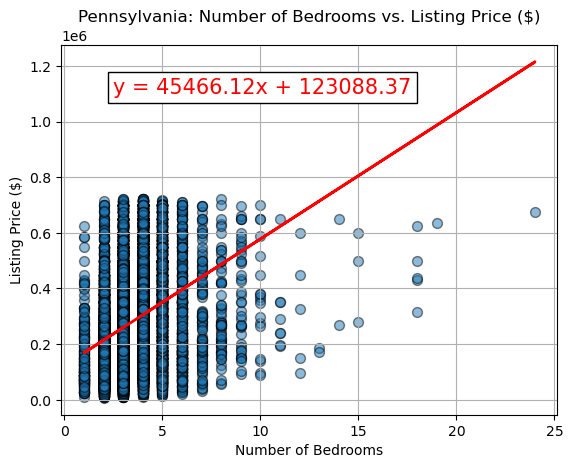

In [43]:
# Determine and visualize the correlation between number of bedrooms and listing price for the Pennsylvania dataset
x_values = pa_df_clean['bed']
y_values = pa_df_clean['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, pa_bedvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (2.5,1100000), fontsize=15, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Number of Bedrooms")
plt.ylabel("Listing Price ($)")
plt.title("Pennsylvania: Number of Bedrooms vs. Listing Price ($)")
print(f"The r-value is: {pa_bedvprice_rvalue}")
print(f"The r-squared value is: {pa_bedvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Pa_Fig1.png")
plt.show()


The r-value is: 0.6217842840485573
The r-squared value is: 0.38661569588977707


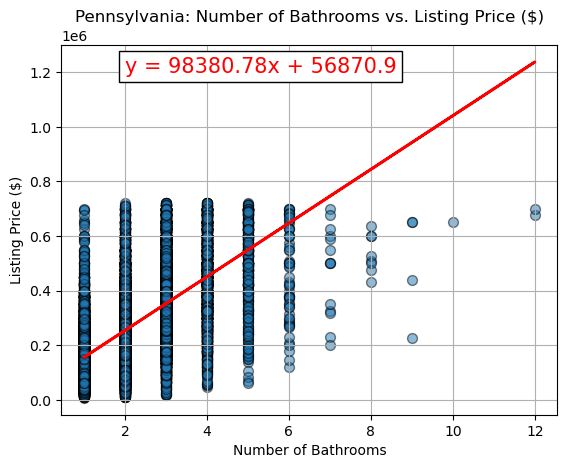

In [44]:
# Determine and visualize the correlation between number of bathrooms and listing price for the Pennsylvania dataset
x_values = pa_df_clean['bath']
y_values = pa_df_clean['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, pa_bathvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (2,1200000), fontsize=15, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Number of Bathrooms")
plt.ylabel("Listing Price ($)")
plt.title("Pennsylvania: Number of Bathrooms vs. Listing Price ($)")
print(f"The r-value is: {pa_bathvprice_rvalue}")
print(f"The r-squared value is: {pa_bathvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Pa_Fig2.png")
plt.show()


The r-value is: 0.010699851602649673
The r-squared value is: 0.00011448682431872477


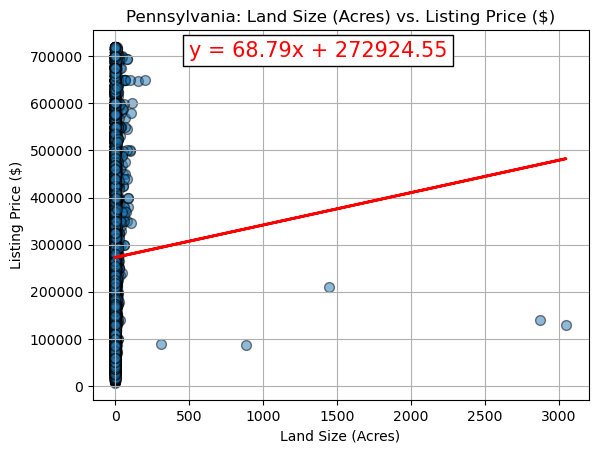

In [45]:
# Determine and visualize the correlation between land size and listing price for the Pennsylvania dataset
x_values = pa_df_clean['acre_lot']
y_values = pa_df_clean['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, pa_landvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (500,700000), fontsize=15, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Land Size (Acres)")
plt.ylabel("Listing Price ($)")
plt.title("Pennsylvania: Land Size (Acres) vs. Listing Price ($)")
print(f"The r-value is: {pa_landvprice_rvalue}")
print(f"The r-squared value is: {pa_landvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Pa_Fig3.png")
plt.show()


The r-value is: 0.06119502463552962
The r-squared value is: 0.0037448310401430773


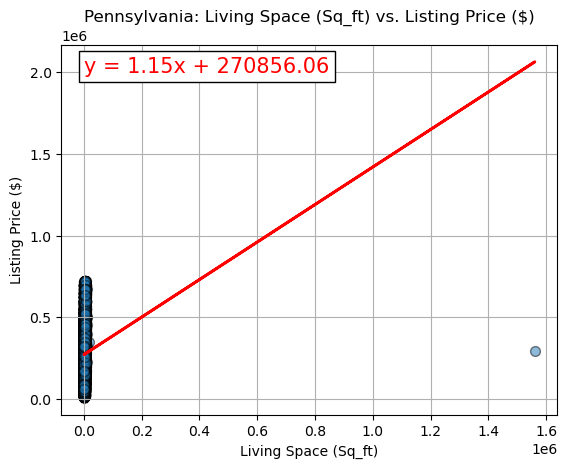

In [46]:
# Determine and visualize the correlation between living space and listing price for the Pennsylvania dataset
x_values = pa_df_clean['house_size']
y_values = pa_df_clean['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, pa_livingvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (2000,2000000), fontsize=15, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Living Space (Sq_ft)")
plt.ylabel("Listing Price ($)")
plt.title("Pennsylvania: Living Space (Sq_ft) vs. Listing Price ($)")
print(f"The r-value is: {pa_livingvprice_rvalue}")
print(f"The r-squared value is: {pa_livingvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Pa_Fig4.png")
plt.show()


### Pennsylvania OpenWeather API for Maximum Temperature Retrieval ###

In [47]:
# Utilize the OpenWeather API to obtain city specific Latitude, Longitude and Maximum Temperature values
# Establish a base url for request as well as an empty lists to hold specified results 
# Utilized a random selection of 600 unique Pennsylvania cities to be within allowed API call range
base_url = "http://api.openweathermap.org/data/2.5/weather?appid=" + openweather_key_three + "&units=imperial" + "&q="
pa_city_data = []
pa_city_names = pa_df_clean['city'].unique()
pa_city_names = list(pa_city_names)
pa_city_names = random.sample(pa_city_names, 600)

# Run for loop for each city
for city in pa_city_names:

    # Establish enpoint target url for each unique city name
    target_url = base_url + city + ",PA,US"

    # Run API request
    try:

        # Parse JSON response and retrieve data
        pa_response = requests.get(target_url).json()

        # Data retrieval for Latitude, Longitude and Max Temperature
        city_lat = pa_response["coord"]["lat"]
        city_long = pa_response["coord"]["lon"]
        city_temp = pa_response["main"]["temp_max"]

        # Add the retrived data to our previously established dictionary
        pa_city_data.append({"city": city,
                            "Latitude": city_lat,
                            "Longitude": city_long,
                            "Max Temperature": city_temp})

    # Include an except clause to handle potential errors and skip to the next city
    except:
        print(f"City not found: {city}")
        pass

# Display when process is complete
print("Data Retrieval Complete!")

City not found: Fell Township
City not found: Artemas
City not found: Williams Township
City not found: Palmer Township
City not found: Upper Mt Bethel
City not found: Waverly Township
City not found: North Abington Township
City not found: South Whitehall Township
City not found: South Abington
City not found: Upper Macungie Township
City not found: Pocono Township
City not found: Bradfordwoods
City not found: Valley Township
City not found: Cranberry Township
City not found: Wilcox Pa
City not found: Le Raysville
City not found: Emporium Pa
City not found: South Abington Township
City not found: Etters
City not found: Natrona Heights
City not found: Jenkins Township
City not found: Forkston Township
City not found: Spring Brook Township
City not found: New Bethlehem
City not found: Upper Mt Bethel Township
City not found: Weisenberg Township
City not found: Pittston Township
City not found: Merion Station
City not found: Coal Township
City not found: West Brandywine
City not found: F

In [48]:
# Convert our populated dictionary into a dataframe and display
pa_city_data_df = pd.DataFrame(pa_city_data)
pa_city_data_df

,city,Latitude,Longitude,Max Temperature
0,Ligonier,40.2431,-79.2375,72.19
1,Wormleysburg,40.2629,-76.9139,75.33
2,Beaver Meadows,40.9281,-75.9146,68.41
3,Oreland,40.1184,-75.1777,67.57
4,Saint Thomas,29.8935,-91.0068,86.04
...,...,...,...,...
556,York,40.1254,-77.0000,74.62
557,Mill Creek,40.4356,-77.9308,72.54
558,Stowe,40.2526,-75.6774,69.71
559,Richlandtown,40.4701,-75.3205,67.55


### Pennsylvania Geoapify API for Population Retrieval ###

In [49]:
# Add new column to hold retrieved city population values
pa_city_data_df["Population"] = ""

# Establish base url and params dictionary for API call
base_url = "https://api.geoapify.com/v2/place-details"
params = {
    "apiKey": geoapify_key_two,
}

# Loop through each row (city) within dataframe to obtain population results
for index, row in pa_city_data_df.iterrows():

    # Append appropriate required parameters to return population for each lat/long input
    params["lat"] = row.loc['Latitude']
    params["lon"] = row.loc['Longitude']
    city = row.loc['city']

    # Make API request and convert to JSON format
    response = requests.get(base_url, params=params).json()

    # Append our population column with the retrieved population value and display progress indicator
    try:
        pa_city_data_df.loc[index, "Population"] = response['features'][0]['properties']['datasource']['raw']['population']
        print(f"Population of {city} found")

    # If error encountered, fill population column with NaN and display indicator
    except (KeyError, IndexError):
        pa_city_data_df.loc[index, "Population"] = np.nan
        print(f"Population of {city} not found")

# Print completion message
print("-----------------------")
print("Data Retrieval Complete!")
print("-----------------------")

# Display updated dataframe with returned population values
pa_city_data_df

Population of Ligonier not found
Population of Wormleysburg found
Population of Beaver Meadows not found
Population of Oreland not found
Population of Saint Thomas not found
Population of Uniontown found
Population of Fallsington not found
Population of Gaines found
Population of Greencastle found
Population of Brackney not found
Population of Falls Creek not found
Population of Manheim not found
Population of Grindstone not found
Population of Centre Hall not found
Population of Fayetteville not found
Population of Montoursville not found
Population of New Galilee found
Population of Sheffield found
Population of Beaver not found
Population of Harding not found
Population of Saltsburg not found
Population of Rebuck not found
Population of Butler not found
Population of Royersford found
Population of Wysox found
Population of Lemoyne not found
Population of Akron found
Population of Dimock found
Population of Harford found
Population of Templeton not found
Population of Havertown not f

,city,Latitude,Longitude,Max Temperature,Population
0,Ligonier,40.2431,-79.2375,72.19,NaN
1,Wormleysburg,40.2629,-76.9139,75.33,2647
2,Beaver Meadows,40.9281,-75.9146,68.41,NaN
3,Oreland,40.1184,-75.1777,67.57,NaN
4,Saint Thomas,29.8935,-91.0068,86.04,NaN
...,...,...,...,...,...
556,York,40.1254,-77.0000,74.62,NaN
557,Mill Creek,40.4356,-77.9308,72.54,NaN
558,Stowe,40.2526,-75.6774,69.71,NaN
559,Richlandtown,40.4701,-75.3205,67.55,1478


In [50]:
# Drop all cities where we were unable to retrieve a population value and display dataframe
pa_city_data_df = pa_city_data_df.loc[pd.notna(pa_city_data_df["Population"])]
pa_city_data_df
# This dataframe indicates we were able to obtain Max Temperature and Population results for cities across 252 listings

,city,Latitude,Longitude,Max Temperature,Population
1,Wormleysburg,40.2629,-76.9139,75.33,2647
5,Uniontown,39.9001,-79.7164,73.62,9992
7,Gaines,42.8725,-83.9141,74.53,361
8,Greencastle,39.7904,-77.7278,75.69,3995
16,New Galilee,40.8356,-80.3995,71.56,396
...,...,...,...,...,...
544,Marietta,40.0570,-76.5522,75.69,2599
546,Eldred,39.2875,-90.5523,66.16,205
549,Darby,39.9184,-75.2591,68.68,10007
551,Wyalusing,42.9439,-91.1415,69.69,374


In [51]:
# Merge our temperature and population dataframe with our master Pennsylvania dataframe & display
# Execute left merge to maintain original dataframe integrity prior to dropping null values in combine dataframe
pa_merged = pd.merge(pa_df_clean, pa_city_data_df, how='left', on='city')
pa_merged

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,Latitude,Longitude,Max Temperature,Population
0,for_sale,279900,3,3,1.14,Lower Mt Bethel Township,Pennsylvania,18013,1865,2017-08-01,NaN,NaN,NaN,NaN
1,for_sale,129900,3,1,0.56,East Stroudsburg,Pennsylvania,18301,1050,1970-11-10,NaN,NaN,NaN,NaN
2,for_sale,189900,2,3,0.03,Stroudsburg,Pennsylvania,18360,1230,2005-04-01,NaN,NaN,NaN,NaN
3,for_sale,259900,3,2,0.13,East Stroudsburg,Pennsylvania,18301,1306,2021-09-03,NaN,NaN,NaN,NaN
4,for_sale,135900,3,1,0.09,Bangor,Pennsylvania,18013,904,2019-03-26,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40052,sold,325000,4,3,1.25,Ellwood City,Pennsylvania,16117,2028,2022-03-01,NaN,NaN,NaN,NaN
40053,sold,210000,3,2,0.50,Beaver Falls,Pennsylvania,15010,2016,2022-04-22,NaN,NaN,NaN,NaN
40054,sold,219000,7,4,0.16,New Brighton,Pennsylvania,15066,5600,2022-04-21,NaN,NaN,NaN,NaN
40055,sold,169900,2,1,1.09,New Castle,Pennsylvania,16105,1165,2021-11-09,NaN,NaN,NaN,NaN


In [52]:
# Drop all rows where we were unable to populate both temperature and population
pa_merged = pa_merged.dropna()
pa_merged
# This dataframe indicates we were able to obtain Max Temperature and Population results across 5,683 listings

,status,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,Latitude,Longitude,Max Temperature,Population
141,for_sale,218900,3,2,0.80,Hawley,Pennsylvania,18428,1160,2003-02-03,41.4759,-75.1821,70.21,1299
286,for_sale,219900,3,2,0.14,East Bangor,Pennsylvania,18013,1602,2005-04-08,40.8795,-75.1838,68.04,1033
312,for_sale,239900,3,2,0.42,East Bangor,Pennsylvania,18013,3050,2011-09-19,40.8795,-75.1838,68.04,1033
322,for_sale,239900,2,2,0.12,East Bangor,Pennsylvania,18013,1150,2012-07-20,40.8795,-75.1838,68.04,1033
340,for_sale,189900,3,1,0.19,Bensalem,Pennsylvania,19020,936,2009-11-19,40.1046,-74.9513,67.33,58751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40025,sold,97500,3,2,0.17,Conneaut Lake,Pennsylvania,16316,1632,2021-12-30,41.6034,-80.3053,70.56,621
40037,sold,325000,4,4,1.25,Conneaut Lake,Pennsylvania,16316,3041,2021-11-01,41.6034,-80.3053,70.56,621
40038,sold,165000,2,2,1.08,Conneaut Lake,Pennsylvania,16316,1682,2021-12-06,41.6034,-80.3053,70.56,621
40042,sold,49900,2,2,0.21,Conneaut Lake,Pennsylvania,16316,1100,2022-02-18,41.6034,-80.3053,70.56,621


The r-value is: -0.19961511066049656
The r-squared value is: 0.039846192404002286


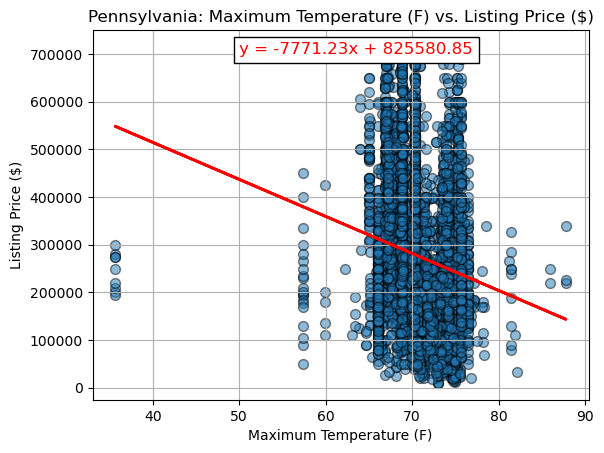

In [53]:
# Determine and visualize the correlation between maximum temperature and listing price for the merged Pennsylvania dataset
x_values = pa_merged['Max Temperature']
y_values = pa_merged['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, pa_tempvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (50,700000), fontsize=12, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Maximum Temperature (F)")
plt.ylabel("Listing Price ($)")
plt.title("Pennsylvania: Maximum Temperature (F) vs. Listing Price ($)")
print(f"The r-value is: {pa_tempvprice_rvalue}")
print(f"The r-squared value is: {pa_tempvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Pa_Fig5.png")
plt.show()


In [54]:
# Convert population column from object to float datatype for regression calculation
pa_merged['Population'] = pa_merged['Population'].astype(float)

/var/folders/jt/y3cfddrx4zsdlyrvrktbcyl40000gn/T/ipykernel_76331/3921172040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pa_merged['Population'] = pa_merged['Population'].astype(float)


The r-value is: 0.028446495983205734
The r-squared value is: 0.00080920313372254


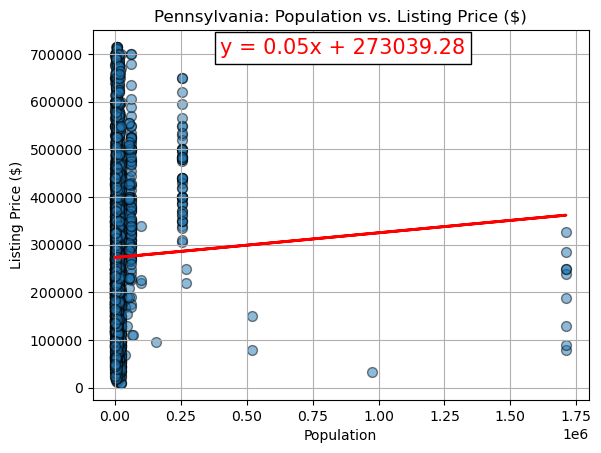

In [55]:
# Determine and visualize the correlation between population and listing price for the merged Pennsylvania dataset
x_values = pa_merged['Population']
y_values = pa_merged['price']
plt.scatter(x_values, y_values, edgecolor='black', alpha=0.5, s=50)

# Calculate linear regression equation, associated r/r-squared values, incorporate appropiate labeling and display
(slope, intercept, pa_popvprice_rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_equation = "y = " + str(slope.round(2)) + "x + " + str(intercept.round(2))
plt.plot(x_values, regress_values, "r-", linewidth=2)
plt.annotate(line_equation, (400000,700000), fontsize=15, color='r', bbox=dict(facecolor='white', edgecolor='black'))
plt.xlabel("Population")
plt.ylabel("Listing Price ($)")
plt.title("Pennsylvania: Population vs. Listing Price ($)")
print(f"The r-value is: {pa_popvprice_rvalue}")
print(f"The r-squared value is: {pa_popvprice_rvalue**2}")
plt.grid()
plt.savefig("image_files/Pa_Fig6.png")
plt.show()


### State Price Comparisons: R-Values & Measures of Central Tendency + Max/Min ###

In [56]:
# Create three individual dictionaries for each state containing respective r-values from regression/correlative analysis
wi_r_value_dict = {"Bed": wi_bedvprice_rvalue, "Bath": wi_bathvprice_rvalue, "Land": wi_landvprice_rvalue, "Living": wi_livingvprice_rvalue, "Population": wi_popvprice_rvalue, "Temperature": wi_tempvprice_rvalue} 
wa_r_value_dict = {"Bed": wa_bedvprice_rvalue, "Bath": wa_bathvprice_rvalue, "Land": wa_landvprice_rvalue, "Living": wa_livingvprice_rvalue, "Population": wa_popvprice_rvalue, "Temperature": wa_tempvprice_rvalue} 
pa_r_value_dict = {"Bed": pa_bedvprice_rvalue, "Bath": pa_bathvprice_rvalue, "Land": pa_landvprice_rvalue, "Living": pa_livingvprice_rvalue, "Population": pa_popvprice_rvalue, "Temperature": pa_tempvprice_rvalue} 

In [57]:
# Turn the dictionaries into series for future aggregation into a single dataframe
wi_r_value_series = pd.Series(wi_r_value_dict)
wa_r_value_series = pd.Series(wa_r_value_dict)
pa_r_value_series = pd.Series(pa_r_value_dict)

In [58]:
# Print series to visualize and ensure accuracy
print(wi_r_value_series)
print(wa_r_value_series)
print(pa_r_value_series)

Bed            0.334675
Bath           0.627064
Land           0.109159
Living         0.636517
Population    -0.005564
Temperature    0.249018
dtype: float64
Bed            0.346287
Bath           0.491463
Land           0.105209
Living         0.573546
Population     0.032312
Temperature   -0.200582
dtype: float64
Bed            0.292631
Bath           0.621784
Land           0.010700
Living         0.061195
Population     0.028446
Temperature   -0.199615
dtype: float64


In [59]:
# Combine the state series into a single dataframe and display
r_data = pd.DataFrame(data = [wi_r_value_series, wa_r_value_series, pa_r_value_series], index=["Wisconsin", "Washington", "Pennsylvania"])
r_data

,Bed,Bath,Land,Living,Population,Temperature
Wisconsin,0.334675,0.627064,0.109159,0.636517,-0.005564,0.249018
Washington,0.346287,0.491463,0.105209,0.573546,0.032312,-0.200582
Pennsylvania,0.292631,0.621784,0.010700,0.061195,0.028446,-0.199615


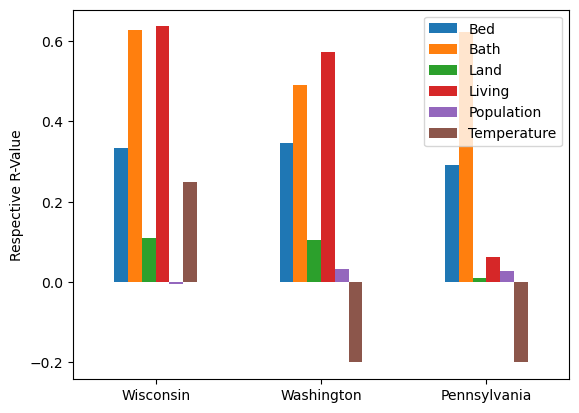

In [60]:
# Plot the state r-value dataframe for comparison visualization and anlysis
r_data.plot(kind='bar')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.ylabel("Respective R-Value")
plt.savefig("image_files/Group_Fig1.png")
plt.show()

In [61]:
# Create three individual dictionaries for each state containing respective measure of central tendency & max/mins
wi_measures_dict = {"Mean": wi_prices_mean, "Median": wi_prices_median, "Mode": wi_prices_mode, "Maximum": wi_prices_max, "Minimum": wi_prices_min} 
wa_measures_dict = {"Mean": wa_prices_mean, "Median": wa_prices_median, "Mode": wa_prices_mode, "Maximum": wa_prices_max, "Minimum": wa_prices_min} 
pa_measures_dict = {"Mean": pa_prices_mean, "Median": pa_prices_median, "Mode": pa_prices_mode, "Maximum": pa_prices_max, "Minimum": pa_prices_min} 

In [62]:
# Turn the dictionaries into series for future aggregation into a single dataframe
wi_measures_series = pd.Series(wi_measures_dict)
wa_measures_series = pd.Series(wa_measures_dict)
pa_measures_series = pd.Series(pa_measures_dict)

In [63]:
# Print series to visualize and ensure accuracy
print(wi_measures_series)
print(wa_measures_series)
print(pa_measures_series)

Mean        275966.59124
Median          250000.0
Mode       (149900, 215)
Maximum           694900
Minimum             9900
dtype: object
Mean       631944.843885
Median          559000.0
Mode       (425000, 145)
Maximum          1539000
Minimum            47900
dtype: object
Mean       272983.447687
Median          249000.0
Mode       (199900, 517)
Maximum           719900
Minimum             6500
dtype: object


In [64]:
# Combine the state series into a single dataframe and display
measures_data = pd.DataFrame(data = [wi_measures_series, wa_measures_series, pa_measures_series], index=["Wisconsin", "Washington", "Pennsylvania"])
measures_data

,Mean,Median,Mode,Maximum,Minimum
Wisconsin,275966.591240,250000.0,"(149900, 215)",694900,9900
Washington,631944.843885,559000.0,"(425000, 145)",1539000,47900
Pennsylvania,272983.447687,249000.0,"(199900, 517)",719900,6500


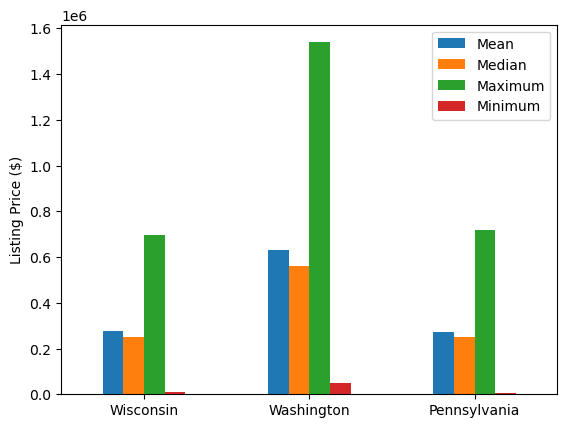

In [65]:
# Plot the state measure of central tendency & max/min dataframe for comparison visualization and anlysis
measures_data.plot(kind='bar')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.ylabel("Listing Price ($)")
plt.savefig("image_files/Group_Fig2.png")
plt.show()